In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d

from skimage import data, io, color
from skimage.transform import resize

plt.rcParams['figure.figsize'] = [10, 10]

def show_plot(image):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.xticks(np.arange(image.shape[0]))
    plt.yticks(np.arange(image.shape[0]))
    plt.colorbar()
    plt.show()
    
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def linear_to_row_col(index, row_width):
    return (index // row_width, index % row_width)

##### Decimation matrix (row major) - assumes only taking 4 neighbours and that $L = M*2$

In [2]:
# l = 4
# m = 2
# d = l // m

# d_matrix = np.zeros((m**2, l**2))

# tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
# t_len = tile.shape[0]

# for p in np.arange(l//4):
#     p_offset = p * l # 8
#     for q in np.arange(m):
#         d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
#         r_offset = m**2 // 2
#         c_offset = l**2 // 2
#         d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant
        
# print(d_matrix)

In [3]:
# x = np.arange(1, 65) # 1..64
# print(x.reshape(8, 8))

# y = np.matmul(d_matrix * 1/4, x)
# print(y.reshape(4, 4))

##### Decimation matrix - downsample matrix $l^2$ by integer factor $n$ (assumes $n$ is suitable factor of $l$ shape)

Sampling regions per dimension: 3
(9, 81)
[0 3 6]
[[0 0]
 [0 3]
 [0 6]
 [3 0]
 [3 3]
 [3 6]
 [6 0]
 [6 3]
 [6 6]]
Index: 0
[ 0  1  2  9 10 11 18 19 20]


Index: 1
[ 3  4  5 12 13 14 21 22 23]


Index: 2
[ 6  7  8 15 16 17 24 25 26]


Index: 3
[27 28 29 36 37 38 45 46 47]


Index: 4
[30 31 32 39 40 41 48 49 50]


Index: 5
[33 34 35 42 43 44 51 52 53]


Index: 6
[54 55 56 63 64 65 72 73 74]


Index: 7
[57 58 59 66 67 68 75 76 77]


Index: 8
[60 61 62 69 70 71 78 79 80]




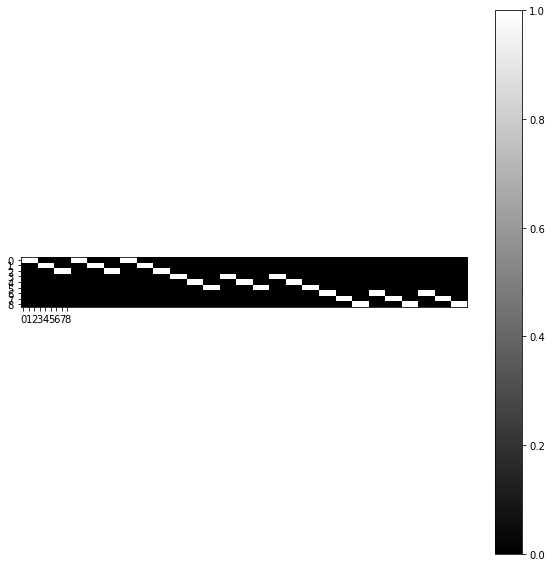

(9,)
[[ 90. 117. 144.]
 [333. 360. 387.]
 [576. 603. 630.]]


In [159]:
def decimation_matrix(original_dim, downsample_factor):
    
    if original_dim % downsample_factor != 0:
        raise ValueError(f"Downsample factor {downsample_factor} is not a valid factor of your matrix dimension {original_dim}.")
    if downsample_factor == original_dim:
        raise ValueError(f"Downsample factor {downsample_factor} cannot be the same as your matrix dimension {original_dim}.")
    if downsample_factor == 1: # effectively, no downsampling
        return np.identity(original_dim**2)
    # Otherwise assumed you want to downsample by a valid factor of original_dim...
    
    sampling_regions_per_dim = original_dim // downsample_factor
    samples_per_region_dim = downsample_factor
    print(f"Sampling regions per dimension: {sampling_regions_per_dim}")
    deci = np.zeros((sampling_regions_per_dim**2, original_dim**2))
    print(deci.shape)
    
    # Points needed for 9x9 down to 3x3...
    # (0,0), (0,3), (0,6), (3,0), (3,3), (3,6), (6,0), (6,3), (6,6)...
    # Generates linear x,y index strides for downsampling
    sample_stride_1D = np.arange(0, original_dim, downsample_factor)
    print(sample_stride_1D)
    mesh = np.array(np.meshgrid(sample_stride_1D, sample_stride_1D))
    sample_strides_2D = mesh.T.reshape(-1, 2)
    print(sample_strides_2D)
  
    neighbour_strides_1D = np.arange(samples_per_region_dim)
    neighbour_mesh = np.array(np.meshgrid(neighbour_strides_1D, neighbour_strides_1D))

    for index in np.arange(sample_strides_2D.shape[0]):
        print(f"Index: {index}")
        neighbour_coords = neighbour_mesh.T.reshape(-1, 2) + sample_strides_2D[index] # generates (row, col) index pair for the nxn neighbours of each sampling point in sample_strides_2D
        neighbour_coords[:, 0] *= original_dim # scale y coord by high-resolution image dim to enable row striding (due to column-vector matrix flattening)
        neighbour_coords = np.sum(neighbour_coords, axis=1) # combine x and y coord into single array index
        print(neighbour_coords)
        deci[index, neighbour_coords] = 1.0
        print()
        print()
        
    return deci
    
# Testing of new decimation matrix routine
l = np.arange(9**2)
# print(l.reshape(8, 8))
d = decimation_matrix(9, 3)
show_plot(d)
m = d @ l
print(m.shape)
print(m.reshape(3, 3))

##### Sharpening matrix (padded)

In [5]:
# x_true = color.rgb2gray(data.astronaut())
# x = resize(x_true, (100, 100), anti_aliasing=True)
# show_plot(x)

# laplace_deblur = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
# scikit_convolved = normalise(convolve2d(x, laplace_deblur, mode="same"))
# show_plot(scikit_convolved)

# l = x.shape[0]
# laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32)
# laplacian_dim = laplacian.shape[0]
# padding = laplacian_dim - 1 # s_matrix padding for out of bounds convolution
# laplacian = laplacian.flatten()
# strided_laplacian = np.insert(laplacian, laplacian_dim, np.repeat(0, l-1))
# strided_laplacian = np.insert(strided_laplacian, laplacian_dim*2+l-1, np.repeat(0, l-1))
# s_matrix = np.zeros(((l+padding)**2, (l+padding)**2), dtype=np.float32)

# for sr in np.arange(l):
#     for r in np.arange(l):
#         row_offset = (sr*l)+(l+padding+padding//2)+(padding*sr)
#         col_offset = sr*(l+padding)+r
#         s_matrix[row_offset+r, col_offset:col_offset+strided_laplacian.shape[0]] = strided_laplacian

# show_plot(s_matrix)
        
# x_padded = np.pad(x, 1)
# x_padded = x_padded.reshape(1, x_padded.shape[0]**2)
# x_padded = np.matmul(s_matrix, x_padded.T)
# x_padded = x_padded.reshape(102, 102)[1:101, 1:101]
        
# show_plot(normalise(x_padded))
# show_plot(scikit_convolved - normalise(x_padded))

##### Sharpening matrix (no padding)

In [6]:
# x_true = color.rgb2gray(data.astronaut())
# x = resize(x_true, (50, 50), anti_aliasing=True)
# show_plot(x)

# l = x.shape[0]

# s_matrix = np.zeros((l**2, l**2))
# # laplace = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
# laplace = np.array([[1, 4, 7, 4, 1], [4, 16, 26, 16, 4], [7, 26, 41, 26, 7], [4, 16, 26, 16, 4], [1, 4, 7, 4, 1]], dtype=np.float32) * 1/273
# kernel_dim = laplace.shape[0]
# kernel_half_supp = (kernel_dim - 1) // 2

# for s_row in np.arange(l**2):
    
#     row, col = linear_to_row_col(s_row, l)
    
#     for k_row in np.arange(-(kernel_half_supp), kernel_half_supp + 1):
#         # map "kernel row" to rows in s_matrix
#         mapped_row = row + k_row
#         # ignore any out of bounds rows
#         if mapped_row >= 0 and mapped_row < l:
#             linear_col = col - kernel_half_supp
#             # truncate negative columns
#             mapped_col_start = max(linear_col, 0)
#             # truncate columns which exceed the l dimension
#             mapped_col_end = min(linear_col + kernel_dim, l)
#             # left trimming for kernels when overlapping out of bounds region in s_matrix (col < 0)
#             left = np.absolute(col - kernel_half_supp) if linear_col < 0 else 0
#             # right trimming for kernels when overlapping out of bounds region in s_matrix (col >= l)
#             right = linear_col + kernel_dim - l if linear_col + kernel_dim >= l else 0 
#             # copy over kernel row for current k_row, possibly including trimming for out of bounds coordinates
#             s_matrix[s_row][mapped_row * l + mapped_col_start : mapped_row * l + mapped_col_end] = laplace[k_row+kernel_half_supp][left: left + kernel_dim - right]

# s_matrix = np.zeros((l**2, l**2))
# show_plot(s_matrix)

# laplace_deblur = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
# scikit_convolved = normalise(convolve2d(x, laplace, mode="same"))
# show_plot(scikit_convolved)

# x = x.reshape(1, x.shape[0]**2)
# x = np.matmul(s_matrix, x.T)
# x = x.reshape(50, 50)
        
# show_plot(normalise(x))
# show_plot(scikit_convolved - normalise(x))

#### $L_{1}$ and $L_{\infty}$ norms of a matrix

In [7]:
# x = np.arange(1, 10).reshape(3, 3)
# print(x)

# # Max absolute column sum of matrix
# l_one = np.max(np.sum(np.absolute(x), axis=0))
# print(l_one)

# # Max absolute row sum of matrix
# l_inf = np.max(np.sum(np.absolute(x), axis=1))
# print(l_inf)